In [1]:
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:

df = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.data', sep='\t',
                 names=['user_id','item_id','rating','tstamp']).sample(frac=1)
df['date'] = pd.to_datetime(df['tstamp'],unit='s')

print(df.head())
items = pd.read_csv('../input/movielens-100k-dataset/ml-100k/u.item', sep='|',
                    names=['movie id' ,'movie title' ,'release date' ,'video release date' ,
                           'IMDb URL' ,'unknown' ,'Action' ,'Adventure' ,'Animation' ,
                           'Children' ,'Comedy' ,'Crime' ,'Documentary' ,'Drama' ,'Fantasy' ,
                           'Film-Noir' ,'Horror' ,'Musical' ,'Mystery' ,'Romance' ,'Sci-Fi' ,
                           'Thriller' ,'War' ,'Western'],encoding='latin')
def get_year(x):
    if pd.isna(x):
        return 0
    else:
        return(int(x[-4:]))
items['year'] = items['release date'].apply(get_year)
items = items.set_index('movie id')
print(items.head)
num_users = len(pd.unique(df['user_id']))
num_movie = len(pd.unique(df['item_id']))

       user_id  item_id  rating     tstamp                date
86238      621      790       4  874963081 1997-09-22 21:18:01
98815      889      161       4  880180897 1997-11-22 06:41:37
26252      184      512       4  889908716 1998-03-14 20:51:56
58271      378      961       3  880055706 1997-11-20 19:55:06
51725        6      519       5  883601365 1997-12-31 20:49:25
<bound method NDFrame.head of                                         movie title release date  \
movie id                                                           
1                                  Toy Story (1995)  01-Jan-1995   
2                                  GoldenEye (1995)  01-Jan-1995   
3                                 Four Rooms (1995)  01-Jan-1995   
4                                 Get Shorty (1995)  01-Jan-1995   
5                                    Copycat (1995)  01-Jan-1995   
...                                             ...          ...   
1678                              Mat' i syn (19

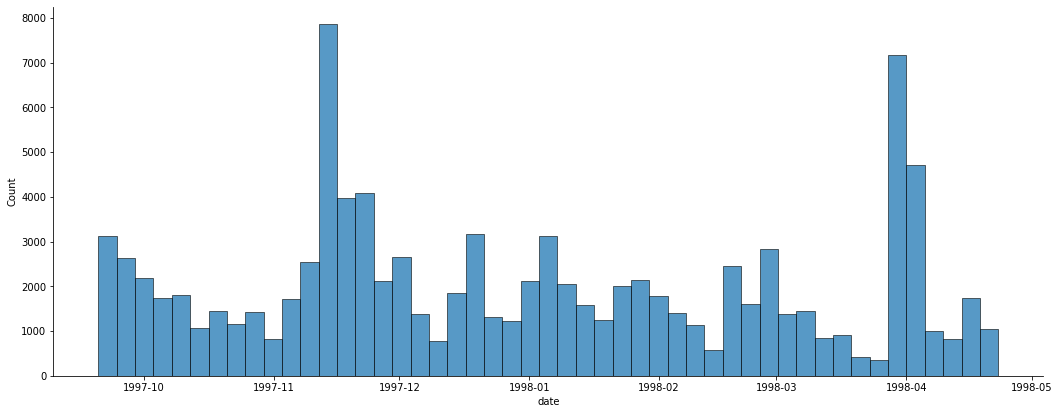

In [3]:
g = sns.displot(df['date'])
g.fig.set_figheight(6)
g.fig.set_figwidth(18)

In [4]:
#Date based split
cutoff_date = '1998-03-01'
df_train = df[df['date'] < cutoff_date]
df_test = df[df['date'] >= cutoff_date]

#Random split
# test_train_split = 0.2
# df_train = df[int(test_train_split*len(df)):]
# df_test = df[:int(test_train_split*len(df))]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

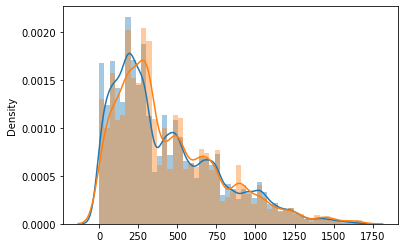

In [5]:
X_train = df_train.drop(columns=['rating','tstamp','date']).to_numpy() - 1
y_train = df_train['rating'].to_numpy()
X_test = df_test.drop(columns=['rating','tstamp','date']).to_numpy() - 1
y_test = df_test['rating'].to_numpy()

sns.distplot(X_train[:,1])
sns.distplot(X_test[:,1])

In [6]:
print(len(np.unique(X_train[:,0])), len(np.unique(X_test[:,0])))
print(len(pd.unique(df['user_id'])))
print(len(np.unique(X_train[:,1])), len(np.unique(X_test[:,1])))
print(len(pd.unique(df['item_id'])))

736 327
943
1608 1467
1682


In [20]:
import tensorflow as tf
def collaborative_model(num_users, num_movies, emb_dim):
    x = tf.keras.Input((2))
    x_user = tf.keras.layers.Embedding(num_users,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='users')(x[:,0])
    x_movie = tf.keras.layers.Embedding(num_movies,emb_dim,
                                       embeddings_regularizer=tf.keras.regularizers.L2(1e-4),
                                       name='movies')(x[:,1])
    out = tf.linalg.diag_part(tf.linalg.matmul(x_user,x_movie,transpose_b=True))
    
    return tf.keras.Model(inputs=x, outputs=out, name="colab_model")

model = collaborative_model(num_users,num_movie,32)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mse'])
model.fit(X_train,y_train,32,40,validation_split=0.1,
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=4,
    restore_best_weights=True
)])    
    
umat = model.get_layer('users').get_weights()[0]
mmat = model.get_layer('movies').get_weights()[0]

Epoch 1/40
2194/2194 [==============================] - 4s 2ms/step - loss: 7.5597 - mse: 7.3833 - val_loss: 2.1533 - val_mse: 1.7474
Epoch 2/40
2194/2194 [==============================] - 3s 2ms/step - loss: 1.7596 - mse: 1.2705 - val_loss: 1.6288 - val_mse: 1.0879
Epoch 3/40
2194/2194 [==============================] - 3s 2ms/step - loss: 1.5641 - mse: 0.9979 - val_loss: 1.5828 - val_mse: 1.0012
Epoch 4/40
2194/2194 [==============================] - 4s 2ms/step - loss: 1.5302 - mse: 0.9386 - val_loss: 1.5733 - val_mse: 0.9757
Epoch 5/40
2194/2194 [==============================] - 4s 2ms/step - loss: 1.5134 - mse: 0.9104 - val_loss: 1.5581 - val_mse: 0.9512
Epoch 6/40
2194/2194 [==============================] - 3s 2ms/step - loss: 1.5001 - mse: 0.8900 - val_loss: 1.5525 - val_mse: 0.9399
Epoch 7/40
2194/2194 [==============================] - 3s 2ms/step - loss: 1.4883 - mse: 0.8724 - val_loss: 1.5566 - val_mse: 0.9402
Epoch 8/40
2194/2194 [==============================] - 3s 2ms

In [21]:
#Experiment - how new datapoints including unseen users and movies interact (cold start problem)
#holdout set 
y_pred = model(X_test)
tf.keras.metrics.mean_squared_error(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=11.815867>

In [22]:
#Experiment - how new datapoints including seen users and movies interact
seen_indices = np.isin(X_test[:,0],X_train[:,0]) & np.isin(X_test[:,1],X_train[:,1])
X_test_seen = X_test[seen_indices]
y_test_seen = y_test[seen_indices]
print(X_test_seen.shape,y_test_seen.shape,X_test.shape)
y_pred = model(X_test_seen)
tf.keras.metrics.mean_squared_error(y_test_seen, y_pred)

(3715, 2) (3715,) (22015, 2)


<tf.Tensor: shape=(), dtype=float32, numpy=1.1599795>

array([[ 343,  243],
       [ 343, 1081],
       [ 343,  315],
       [ 343,  126],
       [ 343,  300],
       [ 343,  190],
       [ 343,  495],
       [ 343,  534],
       [ 343,  287],
       [ 343,  131],
       [ 343, 1282],
       [ 343,  275],
       [ 343,  250],
       [ 343,   95],
       [ 343,    7],
       [ 343,  245],
       [ 343,   86],
       [ 343,  321],
       [ 343, 1013],
       [ 343,  714],
       [ 343, 1006],
       [ 343, 1141],
       [ 343,  297],
       [ 343,  954],
       [ 343,  296],
       [ 343,  284],
       [ 343,  508],
       [ 343,  294],
       [ 343,  247],
       [ 343,  254]])

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE()
users = tsne.fit_transform(model.get_layer('users').get_weights()[0])
movies = tsne.fit_transform(model.get_layer('movies').get_weights()[0])
new_df = pd.DataFrame(movies)
new_df[2] = items[1].to_numpy()
new_df[3] = items.drop(columns=[0,1,2,3,4]).idxmax(axis=1)

fig = px.scatter(new_df, x=0, y=1,hover_data=[2],color=3)
fig.show()

In [ ]:
eval_user = 56
items.iloc[X_test[X_test[:,0]==eval_user][:,1]][1]

In [ ]:
user_df = df[df[0]==eval_user]
user_df[5] = items.iloc[user_df[1].to_numpy()][1].to_numpy()
print(user_df[user_df[2]>3])

In [ ]:
top_10_sorted_movies = tf.argsort(tf.linalg.matmul(mmat,tf.expand_dims(umat[eval_user,:],axis=1)),
                           axis=0,direction='DESCENDING')[:10,0]
items.iloc[top_10_sorted_movies]

In [ ]:
#Add regularization
#split the data as per time


In [ ]:
import seaborn as sns
sns.displot(items[items['year']>1990]['year'])